In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from google.colab import files
import zipfile
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Mengunggah file zip
uploaded = files.upload()

# Mendapatkan nama file zip yang diunggah
zip_filename = next(iter(uploaded))

# Membaca file zip
with zipfile.ZipFile(io.BytesIO(uploaded[zip_filename]), 'r') as zip_ref:
    # Ekstrak semua file dalam zip
    zip_ref.extractall()

Saving jerawat_dataset.zip to jerawat_dataset.zip


In [5]:
dataset_path = 'jerawat_dataset'

In [6]:
labels_jerawat= ['Blackhead', 'Kistik', 'Nodula', 'Papula', 'Pustula', 'Whitehead']
label_dict = {label: index for index, label in enumerate(labels_jerawat)}

In [76]:
# Solusi
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

In [77]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),  # Sesuaikan ukuran dengan input model pre-trained
    color_mode='rgb',  # Model pre-trained membutuhkan gambar RGB
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 89 images belonging to 6 classes.
Found 20 images belonging to 6 classes.


In [78]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [86]:
# Solusi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [87]:
# Freeze the base model
base_model.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 6)                 774       
                                                     

In [73]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [85]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') is not None and logs.get('val_accuracy') >= 0.72):
            print("\nAkurasi telah mencapai 88%!")
            self.model.stop_training = True

In [88]:
Callback = myCallback()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=Callback
)

Epoch 1/100
3/3 [==============================] - 2s 222ms/step - loss: 1.9784 - accuracy: 0.1798 - val_loss: 1.7109 - val_accuracy: 0.3000
Epoch 2/100
3/3 [==============================] - 1s 215ms/step - loss: 1.7619 - accuracy: 0.3034 - val_loss: 1.7013 - val_accuracy: 0.3500
Epoch 3/100
3/3 [==============================] - 1s 176ms/step - loss: 1.7308 - accuracy: 0.2472 - val_loss: 1.6992 - val_accuracy: 0.2500
Epoch 4/100
3/3 [==============================] - 1s 194ms/step - loss: 1.6546 - accuracy: 0.2697 - val_loss: 1.6943 - val_accuracy: 0.2500
Epoch 5/100
3/3 [==============================] - 1s 196ms/step - loss: 1.5359 - accuracy: 0.4382 - val_loss: 1.6667 - val_accuracy: 0.2500
Epoch 6/100
3/3 [==============================] - 1s 198ms/step - loss: 1.5278 - accuracy: 0.3596 - val_loss: 1.6448 - val_accuracy: 0.2500
Epoch 7/100
3/3 [==============================] - 1s 217ms/step - loss: 1.4882 - accuracy: 0.4607 - val_loss: 1.6115 - val_accuracy: 0.2500
Epoch 8/100
3

In [89]:
# Evaluasi model
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Akurasi pada data validasi: {test_acc * 100:.2f}%')

1/1 [==============================] - 0s 114ms/step - loss: 1.4550 - accuracy: 0.5500
Akurasi pada data validasi: 55.00%


In [109]:
uploaded = files.upload()

# Simpan nama gambar yang diunggah
image_files = list(uploaded.keys())

Saving jerawat white.jpg to jerawat white (2).jpg


In [110]:
# Fungsi untuk memprediksi gambar
def predict_image(model, image_path, label_map):
    # Membaca gambar dan mengubahnya menjadi array numpy
    img = Image.open(image_path).convert('RGB')  # Convert ke RGB
    img = img.resize((64, 64))  # Resize gambar ke ukuran yang diharapkan oleh model
    img_array = np.array(img) / 255.0  # Normalisasi nilai pixel

    # Menambah dimensi batch karena model membutuhkan batch input
    img_array = np.expand_dims(img_array, axis=0)

    # Melakukan prediksi menggunakan model
    predictions = model.predict(img_array)

    # Mendapatkan kelas prediksi
    predicted_class = np.argmax(predictions[0])

    # Mendapatkan label dari kelas prediksi
    predicted_label = None
    for label, class_id in label_map.items():
        if class_id == predicted_class:
            predicted_label = label
            break

    return predicted_label

In [111]:
for image_file in image_files:
    predicted_label = predict_image(model, image_file, label_dict)
    print(f'Gambar "{image_file}": Prediksi - {predicted_label}')

1/1 [==============================] - 0s 18ms/step
Gambar "jerawat white (2).jpg": Prediksi - Whitehead


1/1 [==============================] - 0s 19ms/step


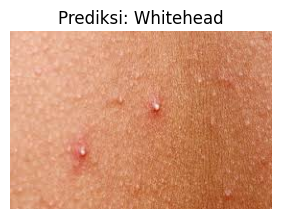

In [113]:
# Tampilkan sampel dan prediksi
plt.figure(figsize=(10, 10))
for i in range(len(image_files)):
    image_file = image_files[i]
    predicted_label = predict_image(model, image_file, label_dict)
    img = Image.open(image_file).convert('RGB')
    plt.subplot(5, 2, i+1)
    plt.imshow(img)
    plt.title(f'Prediksi: {predicted_label}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [114]:
model.save("jerawat_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [115]:
files.download("jerawat_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>